# 4. Mushroom foraging

The [mushroom dataset](https://www.kaggle.com/datasets/dhinaharp/mushroom-dataset) contains data about approximately 60000 mushrooms, and your task is to classify them as either edible or poisonous. You can read about the features [here](https://www.kaggle.com/datasets/uciml/mushroom-classification) and import the data using:

In [28]:
import pandas as pd
pd.set_option('display.max_columns', 1000)
df = pd.read_csv('secondary_data.csv', delimiter = ';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,17.09,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,18.19,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,17.74,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,15.98,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,17.20,s,y,w,u,w,t,p,NaN,d,w


It's up to you how you approach this data, but at a minimum, your analysis should include:

* Informed **data preparation**.
* 2 different classification models, one of which must be **logistic regression**.
* A discussion of which **performance metric** is most relevant for the evaluation of your models.
* 2 different **validation methodologies** used to tune hyperparameters.
* **Confusion matrices** for your models, and associated comments.

In [29]:
# Calculate the percentage of missing values in each column
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage.sort_values(ascending=False)
missing_percentage

veil-type               94.797688
spore-print-color       89.595376
veil-color              87.861272
stem-root               84.393064
stem-surface            62.427746
gill-spacing            41.040462
cap-surface             23.121387
gill-attachment         16.184971
ring-type                4.046243
cap-color                0.000000
cap-shape                0.000000
cap-diameter             0.000000
class                    0.000000
stem-height              0.000000
stem-width               0.000000
does-bruise-or-bleed     0.000000
gill-color               0.000000
has-ring                 0.000000
stem-color               0.000000
habitat                  0.000000
season                   0.000000
dtype: float64

In [30]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import pandas as pd

# Drop columns missing data > 40%
missing_frac = df.isnull().mean()
cols_to_drop = missing_frac[missing_frac > 0.4].index.tolist()
data = df.drop(columns=cols_to_drop)

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Encode categorical columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[cat_cols] = encoder.fit_transform(data[cat_cols])

all_cols = num_cols + cat_cols
imputer = IterativeImputer(max_iter=10, random_state=0)
data[all_cols] = imputer.fit_transform(data[all_cols])

# Decode categorical columns back to original format
data[cat_cols] = encoder.inverse_transform(data[cat_cols])

print(data.isnull().sum())     

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64


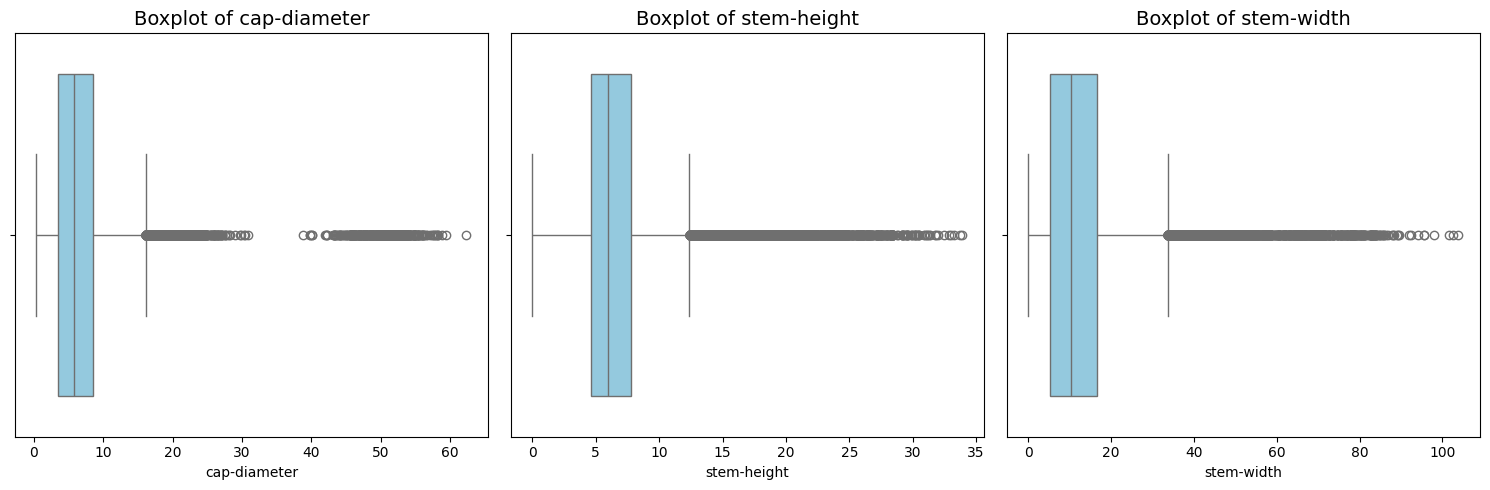

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(ax=axes[i], x=data[col], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}', fontsize=14)
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

In [32]:
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3.0 * IQR 
    upper_bound = Q3 + 3.0 * IQR
    rows_before = data.shape[0]
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    rows_after = data.shape[0]
    print(f"Column '{col}': {rows_before - rows_after} rows removed")
data.head()

Column 'cap-diameter': 437 rows removed
Column 'stem-height': 1065 rows removed
Column 'stem-width': 392 rows removed


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,15.26,x,g,o,f,e,w,16.95,17.09,w,t,g,d,w
3,p,14.17,f,h,e,f,e,w,15.77,15.98,w,t,p,d,w
4,p,14.64,x,h,o,f,e,w,16.53,17.20,w,t,p,d,w
7,p,14.86,x,h,e,f,e,w,17.03,17.44,w,t,p,d,u
9,p,13.55,f,g,e,f,e,w,16.04,16.88,w,t,p,d,w


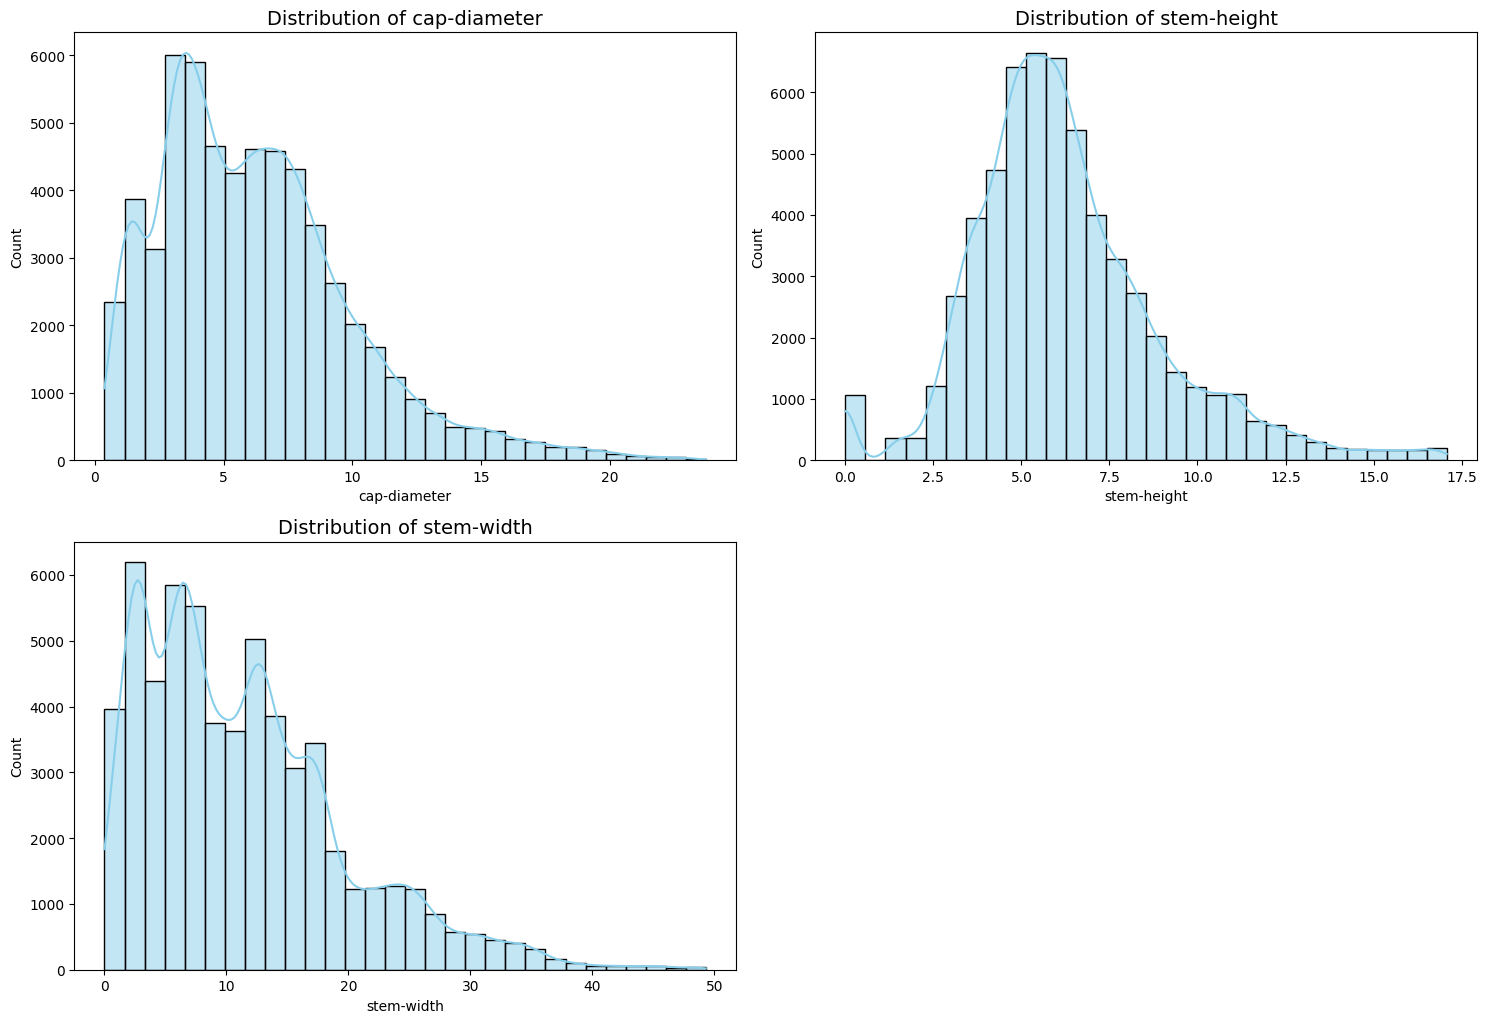

In [33]:
plt.figure(figsize=(15, 5 * len(numerical_cols)))

# Loop through numeric columns and create histograms
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, i + 1)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

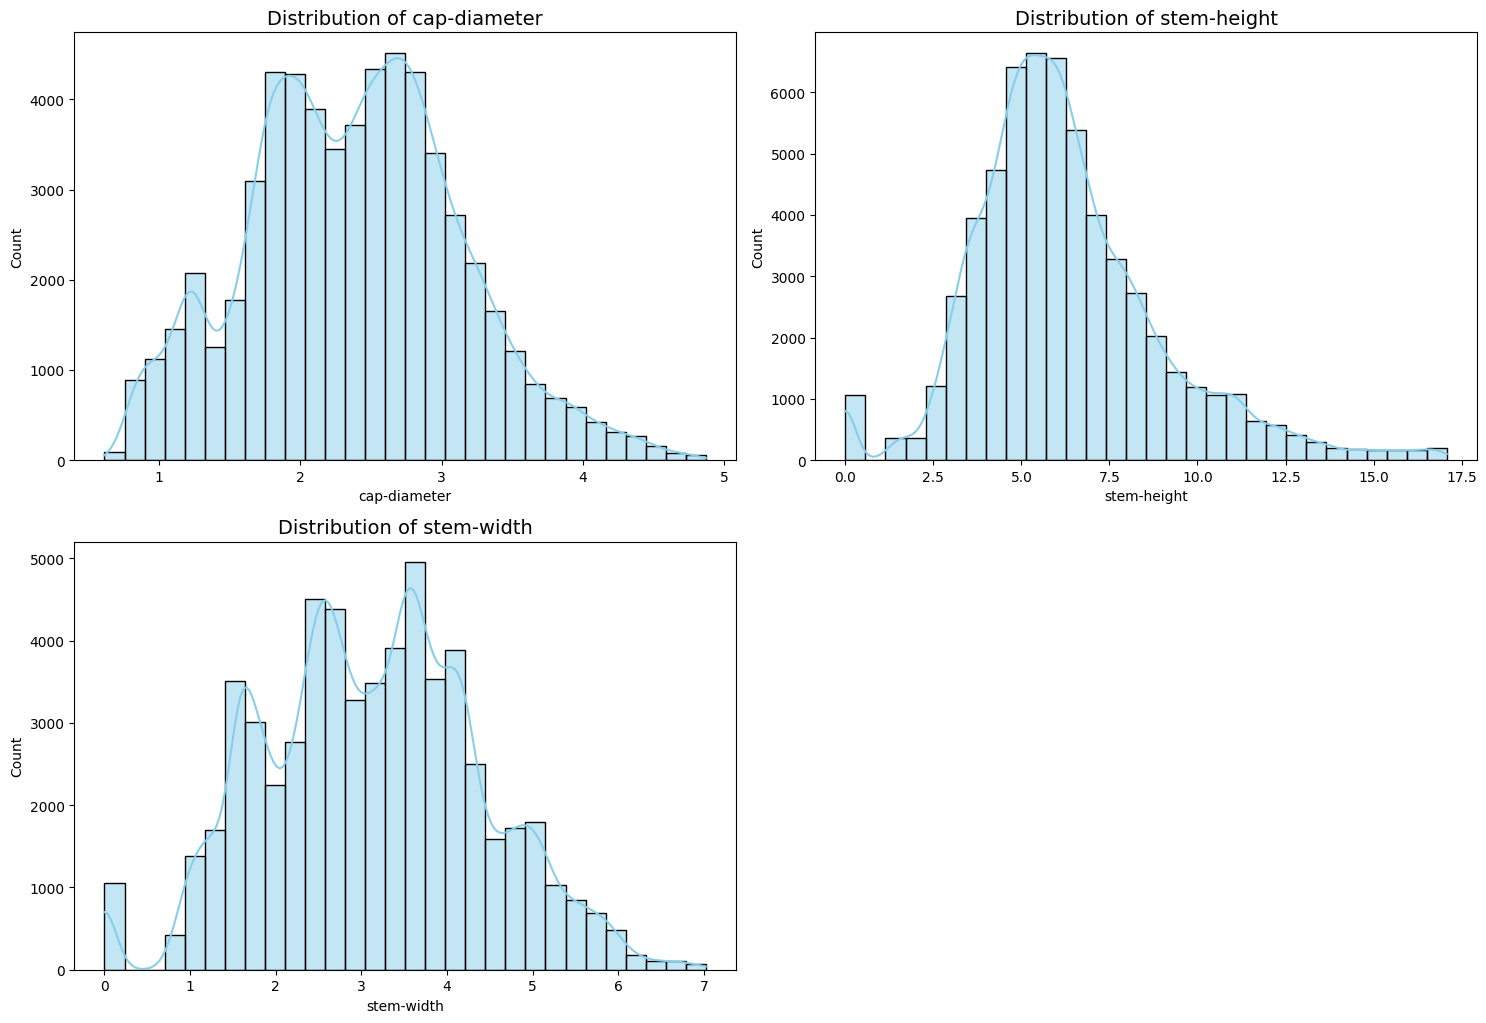

In [34]:
# Apply log transformation to 'cap-diameter' and 'stem-width' columns
data['cap-diameter'] = np.sqrt(data['cap-diameter'])
data['stem-width'] = np.sqrt(data['stem-width'])

plt.figure(figsize=(15, 5 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, i + 1)
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.preprocessing import QuantileTransformer

columns_to_scale = ['cap-diameter', 'stem-height', 'stem-width']
# QuantileTransformer uses uniform distribution
scaler = QuantileTransformer(output_distribution='uniform', random_state=42)
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
data[columns_to_scale].head()

,cap-diameter,stem-height,stem-width
0,0.971259,0.999080,0.790735
3,0.960491,0.994412,0.749550
4,0.965920,0.997427,0.795796
7,0.967778,0.999693,0.806113
9,0.953741,0.995560,0.782783


In [36]:
# Perform one-hot encoding on categorical columns
data = pd.get_dummies(data)

# Convert only the boolean columns to 1 and 0
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)
data.head()

,cap-diameter,stem-height,stem-width,class_e,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,cap-surface_d,cap-surface_e,cap-surface_g,cap-surface_h,cap-surface_i,cap-surface_k,cap-surface_l,cap-surface_s,cap-surface_t,cap-surface_w,cap-surface_y,cap-color_b,cap-color_e,cap-color_g,cap-color_k,cap-color_l,cap-color_n,cap-color_o,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,does-bruise-or-bleed_f,does-bruise-or-bleed_t,gill-attachment_a,gill-attachment_d,gill-attachment_e,gill-attachment_f,gill-attachment_p,gill-attachment_s,gill-attachment_x,gill-color_b,gill-color_e,gill-color_f,gill-color_g,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stem-color_b,stem-color_e,stem-color_f,stem-color_g,stem-color_k,stem-color_l,stem-color_n,stem-color_o,stem-color_p,stem-color_r,stem-color_u,stem-color_w,stem-color_y,has-ring_f,has-ring_t,ring-type_e,ring-type_f,ring-type_g,ring-type_l,ring-type_m,ring-type_p,ring-type_r,ring-type_z,habitat_d,habitat_g,habitat_h,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w
0,0.971259,0.999080,0.790735,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0.960491,0.994412,0.749550,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0.965920,0.997427,0.795796,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
7,0.967778,0.999693,0.806113,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
9,0.953741,0.995560,0.782783,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [37]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['class_p', 'class_e'])
y = data['class_p']

# 64:16:20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_C = 0
best_model_type = ""
best_val_recall = 0
results = {'C': [], 'Penalty': [], 'Recall': []}

# Iterate over both Ridge (L2) and Lasso (L1) regularization
for penalty in ['l2', 'l1']:
    for C in C_values:
        log_reg = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42, max_iter=2000)
        log_reg.fit(X_train, y_train)

        y_pred_val = log_reg.predict(X_val)
        val_recall = recall_score(y_val, y_pred_val)
        results['C'].append(C)
        results['Penalty'].append(penalty)
        results['Recall'].append(val_recall)

        if val_recall > best_val_recall:
            best_val_recall = val_recall
            best_C = C
            best_model_type = penalty

final_model = LogisticRegression(C=best_C, penalty=best_model_type, solver='liblinear', random_state=42, max_iter=200)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

accuracy_train = final_model.score(X_train, y_train)
accuracy_test = final_model.score(X_test, y_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print(f"Best Model Type: {best_model_type}")
print(f"Best C: {best_C}")
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Model Type: l2
Best C: 0.0001
Training Accuracy: 0.6161
Test Accuracy: 0.6249
Precision: 0.6157
Recall: 0.9257


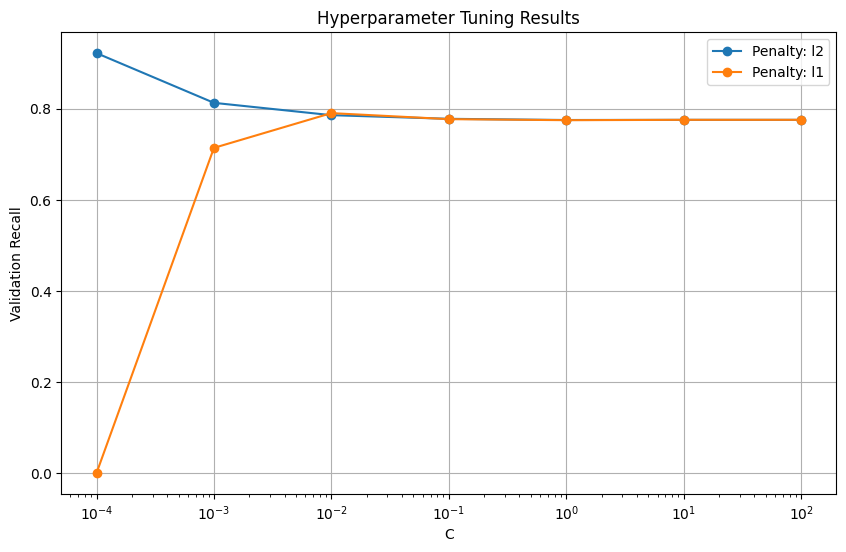

In [39]:

plt.figure(figsize=(10, 6))
for penalty in ['l2', 'l1']:
    subset = [results['Recall'][i] for i in range(len(results['Penalty'])) if results['Penalty'][i] == penalty]
    plt.plot(C_values, subset, marker='o', label=f'Penalty: {penalty}')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Validation Recall')
plt.title('Hyperparameter Tuning Results')
plt.legend()
plt.grid()
plt.show()

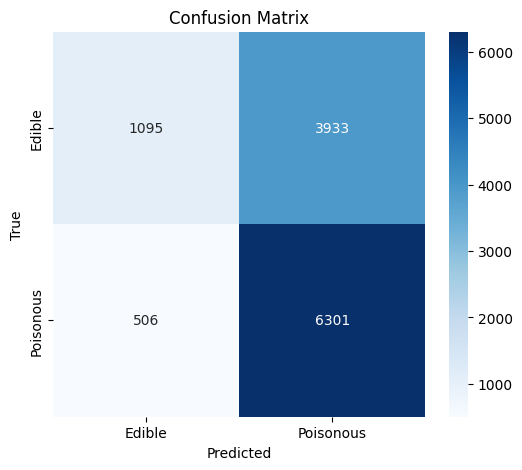

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score

sample_size = 10000  
X_sample = X.sample(n=sample_size, random_state=42)
y_sample = y.loc[X_sample.index] 
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_C = 0
best_kernel = ""
best_test_recall = 0
results = {'C': [], 'Kernel': [], 'Recall': []}

# Iterate over different kernels and C values
for kernel in ['linear', 'rbf']:
    for C in C_values:
        svm = SVC(C=C, kernel=kernel, random_state=42)
        svm.fit(X_train, y_train)

        y_pred_test = svm.predict(X_test)
        test_recall = recall_score(y_test, y_pred_test)
        results['C'].append(C)
        results['Kernel'].append(kernel)
        results['Recall'].append(test_recall)

        if test_recall > best_test_recall:
            best_test_recall = test_recall
            best_C = C
            best_kernel = kernel
        print(f"Kernel: {kernel}, C: {C}, Test Recall: {test_recall:.4f}")

# Train the final model with the best hyperparameters
final_model = SVC(C=best_C, kernel=best_kernel, random_state=42)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

accuracy_train = final_model.score(X_train, y_train)
accuracy_test = final_model.score(X_test, y_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print(f"Best Kernel: {best_kernel}")
print(f"Best C: {best_C}")
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Kernel: linear, C: 1e-05, Test Recall: 1.0000
Kernel: linear, C: 0.0001, Test Recall: 1.0000
Kernel: linear, C: 0.001, Test Recall: 0.9266
Kernel: linear, C: 0.01, Test Recall: 0.8169
Kernel: linear, C: 0.1, Test Recall: 0.7850
Kernel: linear, C: 1, Test Recall: 0.7850
Kernel: linear, C: 10, Test Recall: 0.7841
Kernel: linear, C: 100, Test Recall: 0.7832
Kernel: rbf, C: 1e-05, Test Recall: 1.0000
Kernel: rbf, C: 0.0001, Test Recall: 1.0000
Kernel: rbf, C: 0.001, Test Recall: 1.0000
Kernel: rbf, C: 0.01, Test Recall: 1.0000
Kernel: rbf, C: 0.1, Test Recall: 0.9111
Kernel: rbf, C: 1, Test Recall: 0.9983
Kernel: rbf, C: 10, Test Recall: 0.9974
Kernel: rbf, C: 100, Test Recall: 0.9991
Best Kernel: linear
Best C: 1e-05
Training Accuracy: 0.5745
Test Accuracy: 0.5790
Precision: 0.5790
Recall: 1.0000


In [42]:
import matplotlib.pyplot as plt

sample_size = 5000  
X_sample = X.sample(n=sample_size, random_state=42)
y_sample = y.loc[X_sample.index] 
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Hyperparameter tuning
C_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_C = 0
best_kernel = ""
best_val_recall = 0
results = {'C': [], 'Kernel': [], 'Validation Recall': [], 'Validation Accuracy': []}

# Iterate over different kernels and C values
for kernel in ['linear', 'rbf']:
    for C in C_values:
        svm = SVC(C=C, kernel=kernel, random_state=42)
        svm.fit(X_train, y_train)

        y_pred_val = svm.predict(X_val)
        val_recall = recall_score(y_val, y_pred_val)
        val_accuracy = svm.score(X_val, y_val)
        results['C'].append(C)
        results['Kernel'].append(kernel)
        results['Validation Recall'].append(val_recall)
        results['Validation Accuracy'].append(val_accuracy)

        if val_recall > best_val_recall:
            best_val_recall = val_recall
            best_C = C
            best_kernel = kernel
        print(f"Kernel: {kernel}, C: {C}, Validation Recall: {val_recall:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Train the final model with the best hyperparameters
final_model = SVC(C=best_C, kernel=best_kernel, random_state=42)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

# Evaluate the final model
accuracy_train = final_model.score(X_train, y_train)
accuracy_test = final_model.score(X_test, y_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print(f"Best Kernel: {best_kernel}")
print(f"Best C: {best_C}")
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Kernel: linear, C: 1e-05, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: linear, C: 0.0001, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: linear, C: 0.001, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: linear, C: 0.01, Validation Recall: 0.8553, Validation Accuracy: 0.7350
Kernel: linear, C: 0.1, Validation Recall: 0.8013, Validation Accuracy: 0.7612
Kernel: linear, C: 1, Validation Recall: 0.8013, Validation Accuracy: 0.7712
Kernel: linear, C: 10, Validation Recall: 0.7970, Validation Accuracy: 0.7762
Kernel: linear, C: 100, Validation Recall: 0.7991, Validation Accuracy: 0.7750
Kernel: linear, C: 1000, Validation Recall: 0.7970, Validation Accuracy: 0.7738
Kernel: rbf, C: 1e-05, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: rbf, C: 0.0001, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: rbf, C: 0.001, Validation Recall: 1.0000, Validation Accuracy: 0.5787
Kernel: rbf, C: 0.01, Validation Recall: 1.0000,

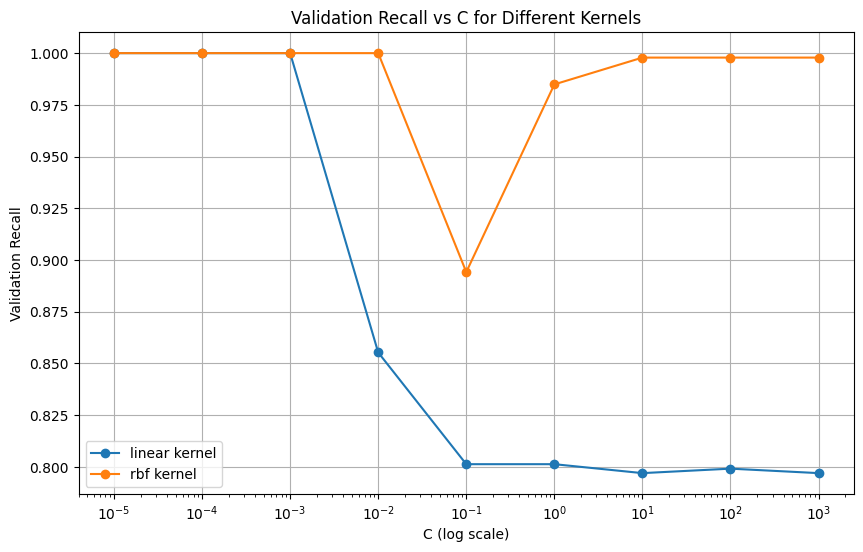

In [43]:

plt.figure(figsize=(10, 6))
for kernel in ['linear', 'rbf']:
    kernel_results = [results['Validation Recall'][i] for i in range(len(results['Kernel'])) if results['Kernel'][i] == kernel]
    plt.plot(C_values, kernel_results, marker='o', label=f'{kernel} kernel')

plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Validation Recall')
plt.title('Validation Recall vs C for Different Kernels')
plt.legend()
plt.grid(True)
plt.show()

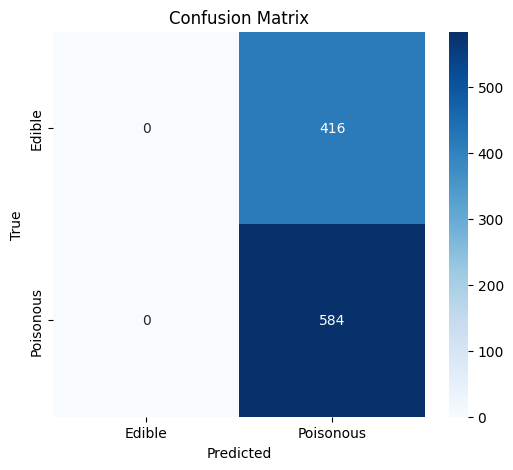

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Train the final model with the best hyperparameters
final_model = SVC(C=100, kernel="rbf", random_state=42)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

# Evaluate the final model
accuracy_train = final_model.score(X_train, y_train)
accuracy_test = final_model.score(X_test, y_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)

print(f"Best Kernel: {best_kernel}")
print(f"Best C: {best_C}")
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Best Kernel: linear
Best C: 1e-05
Training Accuracy: 0.9984
Test Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9966


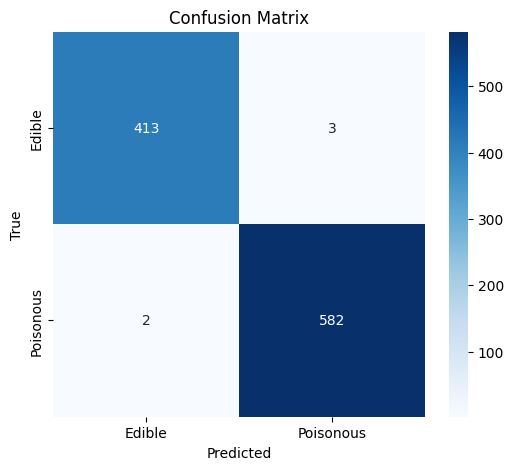

In [46]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible', 'Poisonous'], yticklabels=['Edible', 'Poisonous'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()